# Gait event detection with TKEO

Detect the Foot in and Foot out event from a aceleration signal of a gait cycle

## Load the data

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from  scipy.signal import find_peaks

## Side Function

In [6]:
def TKEO(sig: np.ndarray) -> np.ndarray:
    """Teager kaisor operator on a given signal

    Args:
        sig (np.ndarray): signal to filter

    Returns:
        np.ndarray: filterd signal
    """
    filtered_sig = sig.copy()
    for i in range(1, len(sig)-2):
        filtered_sig[i] = sig[i]**2 - (sig[i-1]*sig[i+1])

    #TODO replace by vector operation for performance optimisation
    # filtered_sig2 = sig.copy()
    # filtered_sig2[1:-1] = sig[1:-1]**2 - (sig[2:]*sig[0:-2])
    return filtered_sig

## Load the data

The Data come from the [NONAN Database](https://springernature.figshare.com/collections/NONAN_GaitPrint_An_IMU_gait_database_of_healthy_young_adults/6415061)

The data has been cleaned to only keep the IMU data of the foot, on one selected gait cycle


In [7]:
df = pd.read_csv(r"./../../data/NONAN_Gaitprint/S001/S001/S001_1_cycle.csv")

In [8]:
df.head()

,Unnamed: 0,time,Foot Accel Sensor X RT (mG),Foot Accel Sensor Y RT (mG),Foot Accel Sensor Z RT (mG),Noraxon MyoMotion-Segments-Foot RT-Acceleration-x (mG),Noraxon MyoMotion-Segments-Foot RT-Acceleration-y (mG),Noraxon MyoMotion-Segments-Foot RT-Acceleration-z (mG),Noraxon MyoMotion-Segments-Foot RT-Gyroscope-x (deg/s),Noraxon MyoMotion-Segments-Foot RT-Gyroscope-y (deg/s),Noraxon MyoMotion-Segments-Foot RT-Gyroscope-z (deg/s)
0,400,2.000,-570.312500,167.480469,797.851562,4.903039,-27.901346,-5.479691,-6.562500,13.289062,-15.390625
1,401,2.005,-579.589844,163.208008,801.757812,1.881335,-23.102726,2.416857,-6.597656,13.367188,-15.867188
2,402,2.010,-583.496094,154.296875,802.246094,-5.259127,-19.391565,3.728211,-6.597656,13.367188,-16.156250
3,403,2.015,-592.773438,130.249023,799.804688,-25.086977,-5.520205,3.679663,-6.562500,13.414062,-16.359375
4,404,2.020,-601.562500,117.004395,797.363281,-34.805053,4.926870,5.047266,-5.656250,13.125000,-16.312500


In [9]:
df.columns

Index(['Unnamed: 0', 'time', 'Foot Accel Sensor X RT (mG)',
       'Foot Accel Sensor Y RT (mG)', 'Foot Accel Sensor Z RT (mG)',
       'Noraxon MyoMotion-Segments-Foot RT-Acceleration-x (mG)',
       'Noraxon MyoMotion-Segments-Foot RT-Acceleration-y (mG)',
       'Noraxon MyoMotion-Segments-Foot RT-Acceleration-z (mG)',
       'Noraxon MyoMotion-Segments-Foot RT-Gyroscope-x (deg/s)',
       'Noraxon MyoMotion-Segments-Foot RT-Gyroscope-y (deg/s)',
       'Noraxon MyoMotion-Segments-Foot RT-Gyroscope-z (deg/s)'],
      dtype='object')

In [10]:
acc_z = df['Foot Accel Sensor Z RT (mG)'].to_numpy()
time = df['time'].to_numpy()
fs = len(time)/time[-1] - time[0]

## Plot the acceleration of one gait cycle

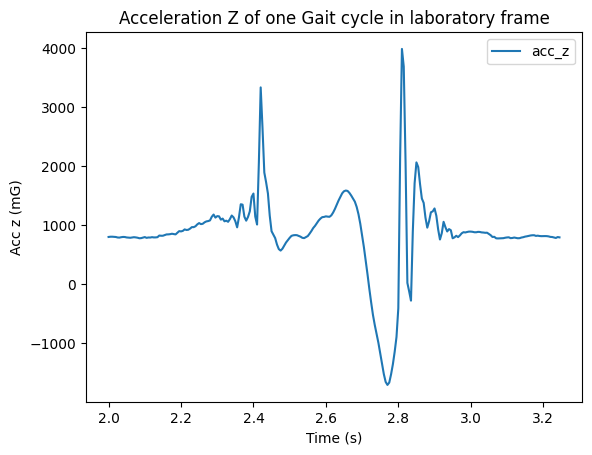

In [11]:
plt.figure()
plt.title("Acceleration Z of one Gait cycle in laboratory frame")
plt.plot(time, acc_z, label="acc_z")
plt.xlabel('Time (s)')
plt.ylabel('Acc z (mG)')
plt.legend()

## Compute the Teager Kaisor Energy Operator

In [12]:
tkeo = TKEO(acc_z)
f_tkeo = np.convolve(np.ones(5)/5, abs(tkeo), mode="same")

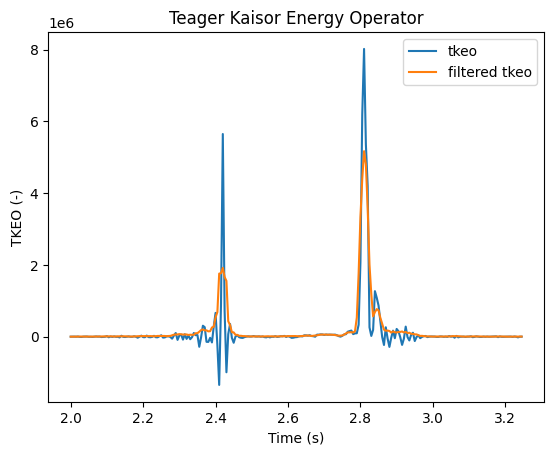

In [13]:
plt.figure()
plt.title("Teager Kaisor Energy Operator")
plt.plot(time, tkeo, label="tkeo")
plt.plot(time, f_tkeo, label="filtered tkeo")
plt.xlabel('Time (s)')
plt.ylabel('TKEO (-)')
plt.legend()


## Find gait events

Find foot in and foot out events by searching maxes on tkeo filtered signal

In [14]:
FI_idx = np.argmax(f_tkeo)
pseudo_mid_swing = np.argmin(f_tkeo[FI_idx-20: FI_idx]) + (FI_idx-20)
FO_idx = np.argmax(f_tkeo[0:pseudo_mid_swing])

FI_time = time[FI_idx]
FO_time = time[FO_idx]

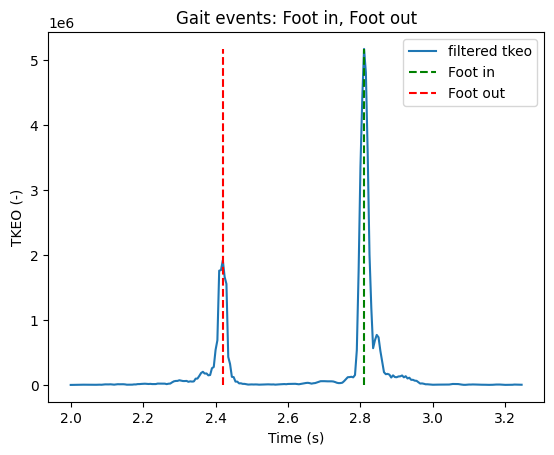

In [15]:

plt.figure()
plt.title("Gait events: Foot in, Foot out")
plt.plot(time, f_tkeo, label="filtered tkeo")
plt.vlines(FI_time, min(f_tkeo), max(f_tkeo), color='green', linestyle='dashed' ,label="Foot in")
plt.vlines(FO_time, min(f_tkeo), max(f_tkeo), color='red', linestyle='dashed' ,label="Foot out")
plt.xlabel('Time (s)')
plt.ylabel('TKEO (-)')
plt.legend()